In [ ]:
# Install required libraries
!pip install tensorflow scikit-learn pandas

In [ ]:
# Import required packages
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from wordcloud import WordCloud
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from google.colab import files, drive

uploaded = files.upload()
file_path = next(iter(uploaded.keys()))
hospital_reviews = pd.read_csv(file_path)

# Display dataset structure
print(hospital_reviews.head())

Saving Final_Updated_Dataset.csv to Final_Updated_Dataset.csv
                                              Review  \
0  There were issues with getting an appointment ...   
1  Overall, it was a pleasant experience, but the...   
2  The nurses were not attentive and seemed indif...   
3          The billing process was smooth and quick.   
4  The pediatric department was very child-friend...   

                Label(insight)  Rating          Hospital Name        Date  \
0           Appointment issues       3  Green Valley Hospital  15-05-2024   
1                 Waiting time       4       Metro Healthcare  14-12-2024   
2               nurse behavior       3  Green Valley Hospital  29-06-2024   
3  Billing is smooth and quick       2       Metro Healthcare  23-02-2024   
4    Child friendly comforting       2        Sunshine Clinic  22-01-2024   

   Sentiment  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4        NaN  


In [ ]:
# Preprocessing function
def preprocess_text_no_nltk(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    stopwords = {
        "the", "and", "is", "in", "to", "a", "of", "for", "on", "this",
        "that", "it", "with", "was", "are", "as", "at", "by", "an", "be",
        "or", "we", "from", "not", "have", "has", "had","there","were","but","very","am" ,"before","here","mamy",
    }
    words = text.split()
    words = [word for word in words if word not in stopwords]
    return ' '.join(words)

# Apply preprocessing
hospital_reviews['cleaned_text'] = hospital_reviews['Review'].apply(preprocess_text_no_nltk)
hospital_reviews[['Review', 'cleaned_text']].head()


,Review,cleaned_text
0,There were issues with getting an appointment ...,issues getting appointment over phone
1,"Overall, it was a pleasant experience, but the...",overall pleasant experience waiting time bit long
2,The nurses were not attentive and seemed indif...,nurses attentive seemed indifferent
3,The billing process was smooth and quick.,billing process smooth quick
4,The pediatric department was very child-friend...,pediatric department childfriendly comforting


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Vectorize cleaned text using TF-IDF
vectorizer = TfidfVectorizer(max_features=2000)
X = vectorizer.fit_transform(hospital_reviews['cleaned_text']).toarray()

# Encode labels using LabelEncoder
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(hospital_reviews['Label(insight)'])

# Split data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
# Encoder model
latent_dim = 16  # Dimension of the latent space

def build_encoder(input_dim):
    inputs = tf.keras.Input(shape=(input_dim,))
    x = layers.Dense(512, activation='relu')(inputs)
    x = layers.Dense(256, activation='relu')(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = layers.Lambda(lambda args: args[0] + tf.exp(0.5 * args[1]) * tf.random.normal(shape=tf.shape(args[0])))([z_mean, z_log_var])
    return tf.keras.Model(inputs, [z_mean, z_log_var, z], name="encoder")

encoder = build_encoder(X_train.shape[1])
encoder.summary()

# Decoder model
def build_decoder(output_dim):
    latent_inputs = tf.keras.Input(shape=(latent_dim,))
    x = layers.Dense(256, activation='relu')(latent_inputs)
    x = layers.Dense(512, activation='relu')(x)
    outputs = layers.Dense(output_dim, activation='sigmoid')(x)
    return tf.keras.Model(latent_inputs, outputs, name="decoder")

decoder = build_decoder(X_train.shape[1])
decoder.summary()

# VAE model
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.square(inputs - reconstructed), axis=1))
        kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))
        self.add_loss(reconstruction_loss + kl_loss)
        return reconstructed

vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())
vae.build(input_shape=(None, X_train.shape[1]))
vae.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 85)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 512)            │         44,032 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │        131,328 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 16)             │          4,112 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 16)             │          4,112 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 16)             │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 183,584 (717.12 KB)

 Trainable params: 183,584 (717.12 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 85)                  │          43,605 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 179,541 (701.33 KB)

 Trainable params: 179,541 (701.33 KB)

 Non-trainable params: 0 (0.00 B)

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder (Functional)                 │ [(None, 16), (None, 16),    │         183,584 │
│                                      │ (None, 16)]                 │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Functional)                 │ (None, 85)                  │         179,541 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 363,125 (1.39 MB)

 Trainable params: 363,125 (1.39 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the VAE
history = vae.fit(X_train, X_train, epochs=20, batch_size=32, validation_data=(X_test, X_test))

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 418ms/step - loss: 19.4590 - val_loss: 15.5990
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 14.7303 - val_loss: 10.0830
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 9.3353 - val_loss: 5.3032
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 4.3666 - val_loss: 2.1530
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 2.3310 - val_loss: 1.5897
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 1.4930 - val_loss: 1.2827
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 1.2770 - val_loss: 1.1248
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 1.1184 - val_loss: 1.0463
Epoch 9/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 1.0443 - val_loss: 1.0084
Epoch 10/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 1.0081 - val_loss: 0.9922
Epoch 11/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.9978 - val_loss: 0.9871
Epoch 12/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.9926 - val_loss: 0.9

In [ ]:
import tensorflow as tf

# Test the model using the test dataset
reconstructed_data = vae.predict(X_test)

# Evaluate reconstruction loss
reconstruction_loss = tf.reduce_mean(
    tf.reduce_sum(tf.square(reconstructed_data), axis=1)
).numpy()
print(f'Reconstruction Loss on Test Data: {reconstruction_loss}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
Reconstruction Loss on Test Data: 0.0013400046154856682


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


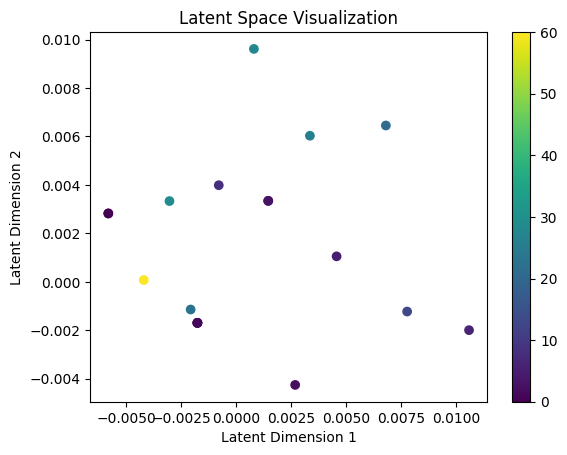

In [ ]:
# Visualize latent space
import matplotlib.pyplot as plt
import numpy as np

z_mean, _, _ = encoder.predict(X_test)
plt.scatter(z_mean[:, 0], z_mean[:, 1], c=np.argmax(X_test, axis=1))
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Latent Space Visualization')
plt.colorbar()
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from google.colab import files, drive
import pandas as pd

uploaded = files.upload()
file_path = next(iter(uploaded.keys()))

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

# Load dataset
# Assume `data.csv` has two columns: 'text' and 'label' (-1, 0, 1)
df = pd.read_csv(file_path)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['label'], test_size=0.2, random_state=42
)

# Text vectorization using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train a Naive Bayes classifier
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

# Predict and evaluate
y_pred = model.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Saving sentimentdata.csv to sentimentdata.csv
Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

          -1       1.00      1.00      1.00         7
           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         5

    accuracy                           1.00        18
   macro avg       1.00      1.00      1.00        18
weighted avg       1.00      1.00      1.00        18



In [ ]:
# Example prediction
example = ["The product is amazing!", "It's okay, not bad", "Terrible experience","it's not so good"]
example_tfidf = vectorizer.transform(example)
predictions = model.predict(example_tfidf)
print("\nExample Predictions:", predictions)


Example Predictions: [ 1  0 -1  0]


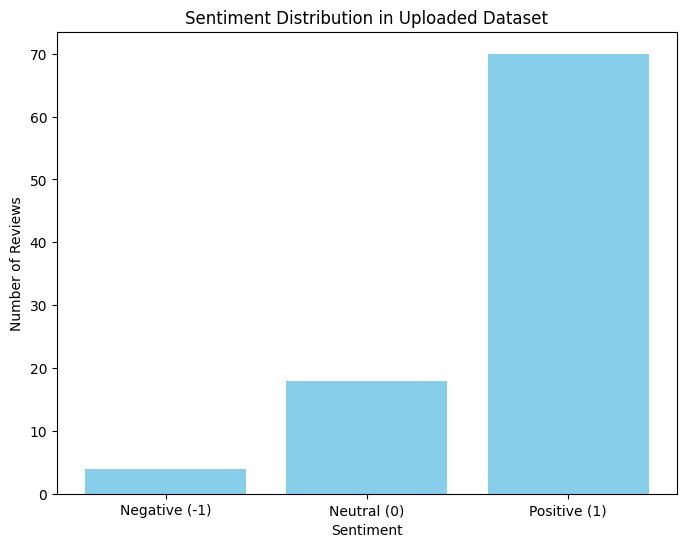

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert text data into numerical feature vectors using the vectorizer
review_vectors = vectorizer.transform(hospital_reviews['Review'])

# Predict sentiment for each review in the dataset
hospital_reviews['Predicted Sentiment'] = model.predict(review_vectors)

# Count sentiment predictions
sentiment_counts = hospital_reviews['Predicted Sentiment'].value_counts()

# Add missing sentiment categories with a count of zero
for sentiment in [-1, 0, 1]:
    if sentiment not in sentiment_counts.index:
        sentiment_counts[sentiment] = 0

# Sort the sentiment counts to ensure consistent order
sentiment_counts = sentiment_counts.sort_index()

# Define label mapping for sentiment categories
label_map = {-1: 'Negative (-1)', 0: 'Neutral (0)', 1: 'Positive (1)'}
labels = [label_map[sentiment] for sentiment in sentiment_counts.index]

# Plot the distribution
plt.figure(figsize=(8, 6))
plt.bar(labels, sentiment_counts.values, color='skyblue')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.title('Sentiment Distribution in Uploaded Dataset')
plt.show()

In [ ]:
import numpy as np
from sklearn.cluster import KMeans

# Initialize KMeans clustering
num_topics = 5  # Number of clusters
kmeans = KMeans(n_clusters=num_topics, random_state=42)
clusters = kmeans.fit_predict(z_mean)

# Normalize cluster centers for keyword distribution
normalized_cluster_centers = np.array([
    (cluster - cluster.min()) / (cluster.max() - cluster.min() + 1e-10)
    for cluster in kmeans.cluster_centers_
])

# Ensure feature names are available
feature_names = vectorizer.get_feature_names_out()

# Function to display unique keywords for each cluster
def display_keywords_unique(cluster_centers, feature_names, top_n=10):
    total_clusters = len(cluster_centers)
    used_words = set()  # Track globally used words
    cluster_keywords = [[] for _ in range(total_clusters)]  # Store keywords for each cluster

    # Sort cluster centers and distribute keywords
    for idx, cluster_center in enumerate(cluster_centers):
        sorted_indices = cluster_center.argsort()[::-1]  # Sort by importance
        for i in sorted_indices:
            word = feature_names[i]
            if word not in used_words:  # Assign only unused words
                cluster_keywords[idx].append(word)
                used_words.add(word)
            if len(cluster_keywords[idx]) == top_n:  # Stop once `top_n` keywords are assigned
                break

    # Handle clusters with fewer than `top_n` keywords
    unused_words = [word for word in feature_names if word not in used_words]
    for idx, keywords in enumerate(cluster_keywords):
        while len(keywords) < top_n and unused_words:
            keywords.append(unused_words.pop(0))  # Assign unused words to fill gaps

    # Print keywords for each cluster
    for idx, keywords in enumerate(cluster_keywords):
        print(f"Cluster {idx}: {', '.join(keywords)}")

# Display unique keywords for clusters
display_keywords_unique(normalized_cluster_centers, feature_names)

Cluster 0: complaints, bought, best, broke, amazing, bad, add, complain, arrived, better
Cluster 1: brilliant, average, absolutely, awful, buy, buying, complete, couldn, customer, damaged
Cluster 2: decent, decide, defective, delivery, described, disappointed, disappointing, disaster, dissatisfied, does
Cluster 3: exceeded, excellent, exceptional, expectations, expected, experience, fantastic, feelings, fine, good
Cluster 4: great, happier, happy, highly, home, horrible, impressive, incredible, indifferent, item


In [ ]:
# Ensure alignment of data used for clustering
if len(z_mean) != len(hospital_reviews):
    print("Mismatch detected. Adjusting...")
    hospital_reviews = hospital_reviews.iloc[:len(z_mean)]  # Align rows

# Assign clusters
hospital_reviews['cluster'] = clusters

# Verify the update
hospital_reviews

Mismatch detected. Adjusting...


<ipython-input-15-345507102948>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hospital_reviews['cluster'] = clusters


,Review,Label(insight),Rating,Hospital Name,Date,Sentiment,cleaned_text,Predicted Sentiment,cluster
0,There were issues with getting an appointment ...,Appointment issues,3,Green Valley Hospital,15-05-2024,NaN,issues getting appointment over phone,1,2
1,"Overall, it was a pleasant experience, but the...",Waiting time,4,Metro Healthcare,14-12-2024,NaN,overall pleasant experience waiting time bit long,0,0
2,The nurses were not attentive and seemed indif...,nurse behavior,3,Green Valley Hospital,29-06-2024,NaN,nurses attentive seemed indifferent,0,4
3,The billing process was smooth and quick.,Billing is smooth and quick,2,Metro Healthcare,23-02-2024,NaN,billing process smooth quick,1,1
4,The pediatric department was very child-friend...,Child friendly comforting,2,Sunshine Clinic,22-01-2024,NaN,pediatric department childfriendly comforting,1,1
5,The hospital cafeteria served decent food.,decent food,4,Metro Healthcare,17-04-2024,NaN,hospital cafeteria served decent food,0,0
6,It was difficult to find parking at the hospital.,difficult parking,4,Metro Healthcare,19-07-2024,NaN,difficult find parking hospital,1,0
7,Had to wait for hours before getting attended to.,wait for hour,2,Green Valley Hospital,17-12-2024,NaN,wait hours getting attended,1,0
8,I found the place to be unhygienic and poorly ...,unhygienic and poor,3,Green Valley Hospital,21-06-2024,NaN,i found place unhygienic poorly maintained,-1,0
9,The staff was very kind and helpful throughout...,Staff kind and helpful,4,Riverfront Medical Center,14-10-2024,NaN,staff kind helpful throughout my visit,1,4


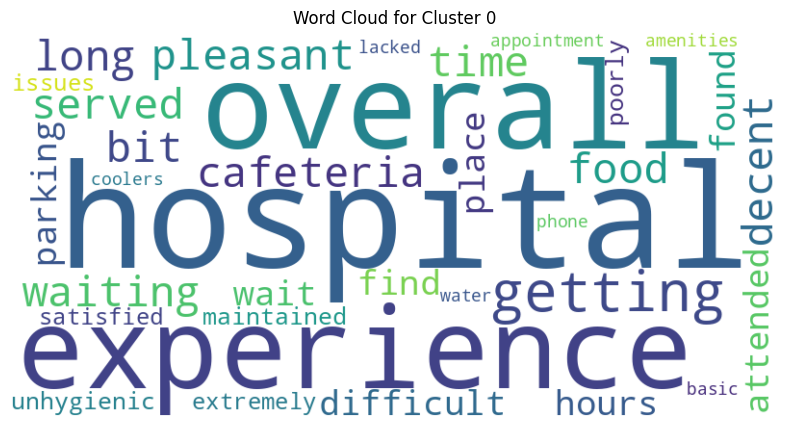

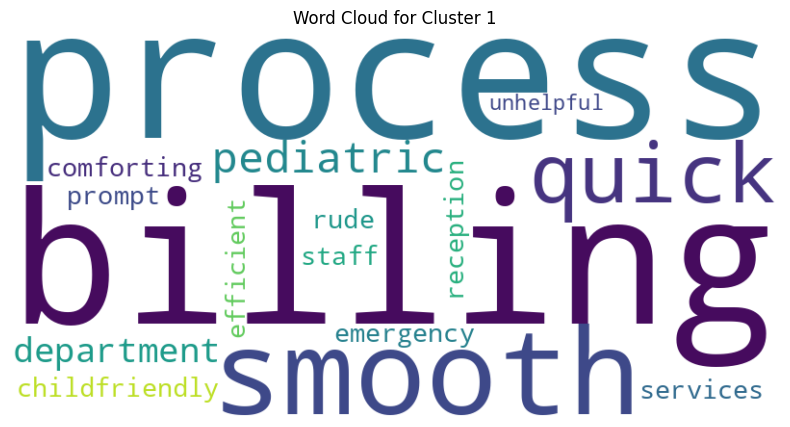

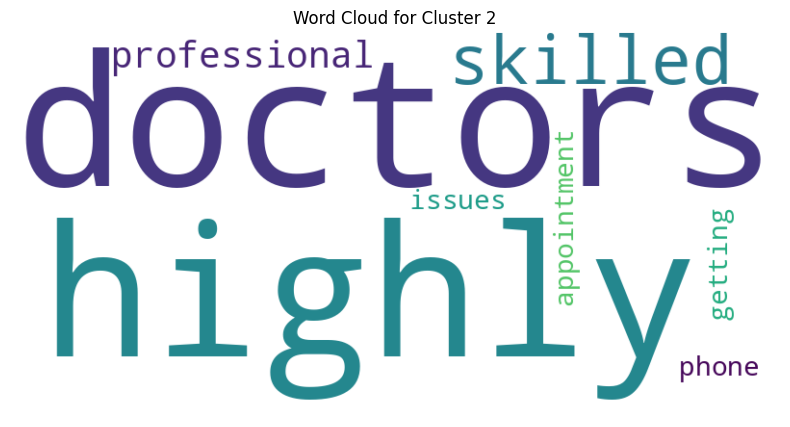

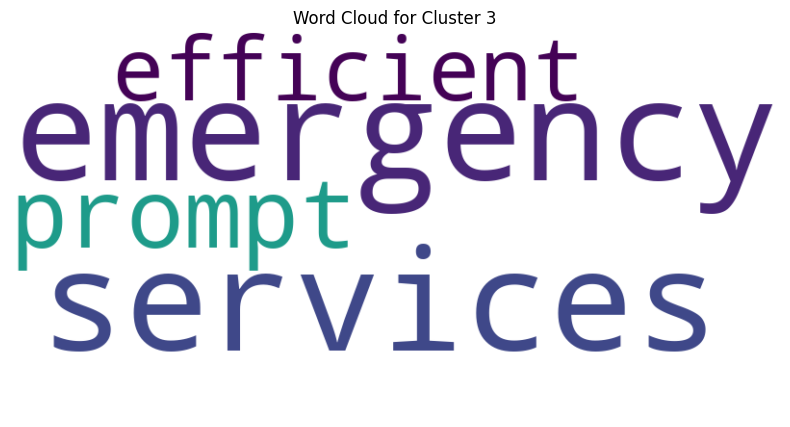

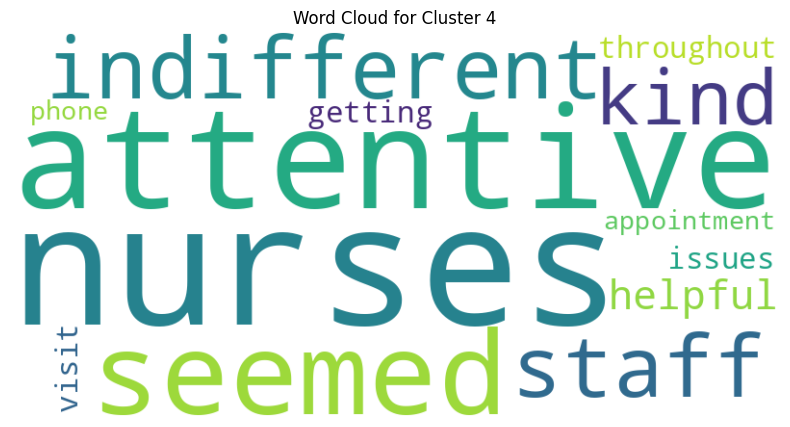

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Ensure each cluster gets visualized with a Word Cloud
for cluster in range(num_topics):
    # Filter the text data for the current cluster
    cluster_texts = hospital_reviews[hospital_reviews['cluster'] == cluster]['cleaned_text']
    if cluster_texts.empty:
        print(f"Cluster {cluster} has no data to display.")
        continue  # Skip if no data for the cluster

    # Combine all text for the cluster
    text = " ".join(cluster_texts)

    # Generate the Word Cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)

    # Plot the Word Cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Remove axes for better visualization
    plt.title(f'Word Cloud for Cluster {cluster}')
    plt.show()

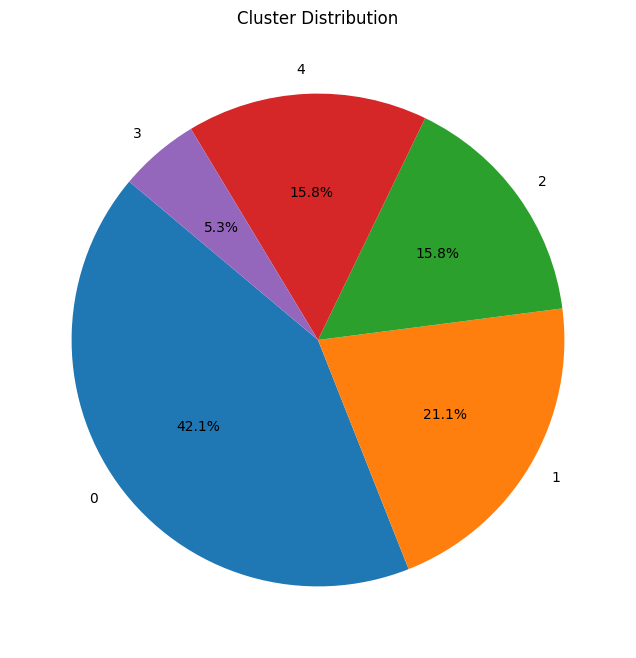

In [ ]:
# Pie Chart for Cluster Distribution
cluster_counts = hospital_reviews['cluster'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(cluster_counts, labels=cluster_counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.tab10.colors)
plt.title("Cluster Distribution")
plt.show()